<h1> DRL Robot Navigation with ROS2 - Documentation </h1>
<h4> Written by Mark Wanis & Jaran Mann, Fall 2025 </h4>

<h4> <b> To-do List: </b> </h4>
<ul>
    <li>Low priority: grasp the basics of the Raspberry Pi Camera</li>
    <li>Recreate tutorial for how to start turtle bot and save all of the data into a file</li>
    <li>Verify encoder-obtained velocity by testing it in the real world</li>
    <li>Learn Gazebo</li>
</ul>

In [16]:
!pip install pandas
!pip install matplotlib

<h2> <b> Code Documentation </b> </h2>

In [ ]:
# Authors: Jaran Mann, Mark Wanis

import rclpy
import math
import numpy as np
import csv

from geometry_msgs.msg import Twist
from nav_msgs.msg import Odometry
from rclpy.node import Node
from rclpy.qos import QoSProfile, ReliabilityPolicy, HistoryPolicy, DurabilityPolicy
from turtlebot3_msgs.msg import SensorState

# The packages for the laser scanner
# Make sure that you have <exec_depend>sensor_msgs</exec_depend> in the xml file
from rclpy.qos import qos_profile_sensor_data
from sensor_msgs.msg import LaserScan
from sensor_msgs.msg import Imu

# The data type for the timestamp
from builtin_interfaces.msg import Time


class Velocity:
    def __init__(self, linear : float=0.0, angular : float=0.0):
        self.linear = linear
        self.angular = angular

    def __str__(self):
        return f"{self.linear:.3f} m/s, {self.angular:.3f} rad/s"

class Point2D:
    def __init__(self, x : float=0.0, y : float=0.0):
        self.x = x
        self.y = y

    def __str__(self):
        return f"({self.x:.3f}, {self.y:.3f})"


class VelocityPublisher(Node):

    def __init__(self):
        super().__init__('VelocityPublisher')

        """************************************************************
        ** Initialise variables
        ************************************************************"""

        # This sets the velocity that we want the robot to move
        self.velocity = Velocity(0.1, 0.0) # unit: m/s, rad/s
        
        # Lidar variables
        self.scannerReceived = False
        self.scan_ranges = []
        self.angle_increment = 0.0
        
        # Odometry variables
        self.odomReceived = False
        self.location_init = Point2D()
        self.location = Point2D()
        
        # Imu variables
        self.imuReceived = False
        self.heading_init = 0.0
        self.heading = 0.0

        # Encoder variables
        self.encReceived = False
        self.left_enc = 0
        self.right_enc = 0
        self.velocity_enc = Velocity()
        self.WHEEL_RADIUS = 0.033 # meters
        self.WHEEL_BASE = 0.160 # meters
        self.TICKS_PER_REV = 4096

        # Timestamp variables
        self.start_time = self.to_seconds(self.get_clock().now().to_msg())
        self.scan_time = 0.0
        self.odom_time = 0.0
        self.imu_time = 0.0
        self.enc_time = 0.0
        self.current_time = 0.0
        
        # Checks whether the data should be saved
        self.save_data = True

        """************************************************************
        ** Initialise ROS publishers and subscribers
        ************************************************************"""

        # A queue with a depth of 10
        qos = QoSProfile(depth=10)
        
        if self.save_data:
            with open("expectedVelocity.csv", mode='w', newline='') as file:
                writer=csv.writer(file)
                writer.writerow(["Time (s)", "Linear Velocity (m/s)", "Angular Velocity (rad/s)"]) 
                
            with open("actualVelocity.csv", mode='w', newline='') as file:
                writer=csv.writer(file)
                writer.writerow(["Time (s)", "Linear Velocity (m/s)", "Angular Velocity (rad/s)"]) 

        # This is the code to create a publisher
        self.cmd_vel_pub = self.create_publisher(Twist, 'cmd_vel', qos)
        
        # Create subscriber to the laser scanner
        self.scan_sub = self.create_subscription(
            LaserScan,
            'scan',
            self.scan_callback,
            qos_profile=qos_profile_sensor_data)
        
        # Create subscriber to odometry
        self.odom_sub = self.create_subscription(
            Odometry,
            'odom',
            self.odom_callback,
            qos)
        
        # Create subscriber to inertial measurement unit
        self.imu_sub = self.create_subscription(
            Imu,
            'imu',
            self.imu_callback,
            qos_profile=qos_profile_sensor_data)
        
        # Create subscriber to the encoders
        self.encoder_sub = self.create_subscription(
            SensorState,
            'sensor_state',
            self.encoder_callback,
            qos)
        
        """************************************************************
        ** Initialise timers
        ************************************************************"""
        
        # This timer is used to update and publish the velocity
        self.velocity_timer = self.create_timer(
            0.1,  # unit: s
            self.velocity_callback)
        
        # This timer is used to update the current time
        self.time_timer = self.create_timer(
            0.01,  # unit: s
            self.update_time)
            
        self.get_logger().info("Turtlebot3 obstacle detection node has been initialised.")

    """*******************************************************************************
    ** Callback functions and relevant functions
    *******************************************************************************"""

    # Updates and publishes the velocity to the robot
    def velocity_callback(self):
        # Creating the data object
        twist = Twist()
        
        # For the first 2 seconds, the robot will not move
        if self.current_time <= 2:
            # linear.x is what is used for the robot to move forward
            # if the time is less than or equal to 2, then set linear.x to the current linear velocity
            twist.linear.x = 0.0
            # angular.z is what is used to turn the robot
            # if the time is less than or equal to 2, then set angular.z to the current angular velocity
            twist.angular.z = 0.0

        # After 2 seconds, the robot will move
        else:
            # if the time is greater than 2, then set linear.x and angular.z to 0.1
            twist.linear.x = self.velocity.linear
            twist.angular.z = self.velocity.angular
        
        # This is how the message is published to the robot
        self.cmd_vel_pub.publish(twist)

        # Save expected velocity data
        if self.save_data:
            with open("expectedVelocity.csv", mode='a', newline='') as file:
                writer=csv.writer(file)
                if self.current_time <= 2:
                    writer.writerow([self.current_time, 0, 0]) 
                else:
                    writer.writerow([self.current_time, self.velocity.linear, self.velocity.angular]) 
        
        self.get_logger().info(f"Expected Velocity: {self.velocity}")
        

    # Updates the current time
    def update_time(self):
        self.current_time = self.get_time(self.get_clock().now().to_msg())
        

    # Every time the laser scanner data has been received from the turtlebot
    def scan_callback(self, msg):
        # Set the scan_ranges list to be the current ranges from the scanner
        self.scan_ranges = msg.ranges
        # Set the angle between the scans
        self.angle_increment = msg.angle_increment

        # Set the time taken for a full scan
        self.scan_time = self.get_time(msg.header.stamp)

        self.scannerReceived = True
        
        # Print values
        self.get_logger().info(f"Scan ranges: {self.scan_ranges[:5]} ... {self.scan_ranges[-5:]}")
        self.get_logger().info(f"\tTime stamp: {self.scan_time:.3f} s")
        
        
    # Every time the odometry data has been received from the turtlebot
    def odom_callback(self, msg):
        # The first time, set the initial values
        if self.odomReceived == False:
            self.location_init.x = msg.pose.pose.position.x
            self.location_init.y = msg.pose.pose.position.y
            self.odomReceived = True
        
        # Determine the x and y location from the difference of the odometry and initial values
        # This way, the values will always start at (0,0)
        self.location.x = msg.pose.pose.position.x - self.location_init.x
        self.location.y = msg.pose.pose.position.y - self.location_init.y

        # Updates the actual velocity found from the odometry
        #self.velocity_odom.linear = msg.twist.twist.linear.x
        #self.velocity_odom.angular = msg.twist.twist.angular.z

        # Set the time taken for the odometry reading
        self.odom_time = self.get_time(msg.header.stamp)
        
        # Print values
        self.get_logger().info(f"Location: {self.location}")
        #self.get_logger().info(f"Actual Velocity: {self.velocity_odom}")
        self.get_logger().info(f"\tTime stamp: {self.odom_time:.3f} s")


    # Every time the inertial subscriber is received from the turtlebot
    def imu_callback(self, msg):
        #get the angle information in quaternion format
        qx = msg.orientation.x
        qy = msg.orientation.y
        qz = msg.orientation.z
        qw = msg.orientation.w
        #convert to Euler angle (we only need z direction)
        t3 = +2.0 * (qw * qz + qx * qy)
        t4 = +1.0 - 2.0 * (qy * qy + qz * qz)
        self.heading = math.atan2(t3, t4)/np.pi #Euler angle in pi-radians (-1 to 1?!)

        if self.heading >= 0:
            self.heading *= math.pi
        else:
            self.heading = self.heading * math.pi + 2.0 * math.pi
            
        if not self.imuReceived:
            self.heading_init = self.heading
            self.imuReceived = True

        # Set the time taken for the imu reading
        self.imu_time = self.get_time(msg.header.stamp)
        
        # Print values
        self.get_logger().info(f"Heading: {self.heading:.3f} rad")
        self.get_logger().info(f"\tTime stamp: {self.imu_time:.3f} s")


    # Every time the encoder subscriber is received from the turtlebot
    def encoder_callback(self, msg):
        if not self.encReceived:
            self.left_en = msg.left_encoder
            self.right_enc = msg.right_encoder
            self.enc_time = self.get_time(msg.header.stamp)
            self.encReceived = True
            return

        # Calculate the change in encoder values
        delta_left = msg.left_encoder - self.left_enc
        delta_right = msg.right_encoder - self.right_enc
        delta_time = self.get_time(msg.header.stamp) - self.enc_time

        if delta_time <= 0:
            return

        # Convert ticks to wheel rotation (radians)
        theta_left = (2 * math.pi * delta_left) / self.TICKS_PER_REV
        theta_right = (2 * math.pi * delta_right) / self.TICKS_PER_REV

        # Calculate the distance each wheel has traveled
        d_left = self.WHEEL_RADIUS * theta_left
        d_right = self.WHEEL_RADIUS * theta_right

        # Update encoder-based velocities
        self.velocity_enc.linear = (d_right + d_left) / (2.0 * delta_time)
        self.velocity_enc.angular = (d_right - d_left) / (self.WHEEL_BASE * delta_time)

        # Update encoder values
        self.left_enc = msg.left_encoder
        self.right_enc = msg.right_encoder

        # Set the time taken for the encoder reading
        self.enc_time = self.get_time(msg.header.stamp)
        
        # Save actual velocity data
        if self.save_data:
            with open("actualVelocity.csv", mode='a', newline='') as file:
                writer=csv.writer(file)
                writer.writerow([self.enc_time, self.velocity_enc.linear, self.velocity_enc.angular]) 

        # Print values
        self.get_logger().info(f"Left Encoder: {self.left_enc}, Right Encoder: {self.right_enc}")
        self.get_logger().info(f"Actual Velocity: {self.velocity_enc}")
        self.get_logger().info(f"\tTime stamp: {self.enc_time:.3f} s")


    # Converts the time data type to seconds as a float
    def to_seconds(self, time) -> float:
        return time.sec + time.nanosec * 1e-9
    

    # Gets the time elapsed since the start of the program as a float
    def get_time(self, time) -> float:
        return self.to_seconds(time) - self.start_time


def main(args=None):
    # This creates the node that publishes to the robot
    rclpy.init(args=args)
    velocity_publisher = VelocityPublisher()
    rclpy.spin(velocity_publisher)

    velocity_publisher.destroy_node()
    rclpy.shutdown()


if __name__ == '__main__':
    main()


<h2> <b> Daily Documentation </b> </h2>

<h3> Date: 9/10/25</h3>

<h4> <b> Meeting Overview: </b> </h4>
<p> We need to get comfortable with manipulating both the inputs and outputs of the robot. </p>

<p> <b> Inputs: </b> </p>
<ul>
<li> Lidar </li>
<li> Odometry </li>
    <ul>
        <li>Position </li>
        <li>Velocity </li>
    </ul>
<li> Gyroscope </li>
    <ul>
        <li>Heading</li>
    </ul>
<li> Raspberry Pi Camera (Low priority)</li>
<li> Time </li>
</ul>

<p> <b> Outputs: </b> </p>
<ul>
<li> Linear Velocity </li>
<li> Angular Velocity </li>
</ul>

<h4> <b> Lab Overview: </b> </h4>

<p> Objective: Tell the robot to go to different spots on the ground while recording all of the data. </p>

<h5> <b> How the program manipulates each input and output </b> </h5>
<ul>
    <li>Lidar</li>
    <li>Odometry</li>
    <ul>
        <li>Position </li>
        <li>Velocity </li>
    </ul>
    <li>Gyroscope</li>
    <ul>
        <li>Heading</li>
    </ul>
    <li> Time </li>
    <li> Linear Velocity </li>
    <li> Angular Velocity </li>
</ul>

<h3> Date: 9/17/25</h3>

<h4> <b> Meeting Overview: </b> </h4>

<h5> <b> To-do List </b> </h5>
<ul>
    <li>Grasp the fundamentals (complete)</li>
    <li>Be able to grab the info and timestamps for each of the inputs and outputs (complete)</li>
    <li>Low priority: grasp the basics of the Raspberry Pi</li>
    <li>Test and graph the response time of the robot's change in linear and angular</li>
    <li>Learn about the gazebo environment and document how to do it</li>
</ul>

<h4> <b> Lab Overview: </b> </h4>

<h5> <b> Outline: </b> </h5>
<ul>
    <li>Worked on printing more variables and finding the timestamps</li>
    <li>Created the Point2D and Velocity classes</li>
</ul>

<h3> Date: 9/22/25</h3>

<h4> <b> Lab Overview: </b> </h4>

<h5> <b> Outline: </b> </h5>
<ul>
    <li>Added imu variables, subscriber, and callback function</li>
    <li>Code runs and prints all of the inputs and outputs</li>
    <li>Started testing and graphing the response time of the robot's change in linear and angular</li>
</ul>

<h3> Date: 9/24/25</h3>

<h4> <b> Meeting Overview: </b> </h4>

<h5> <b> To-do List </b> </h5>
<ul>
    <li>Fix velocity odom by looking up others who have had same problem</li>
    <li>Recreate tutorial for how to start turtle bot and save all of the data into a file</li>
    <li>Learn Gazebo</li>
</ul>

<h4> <b> Lab Overview: </b> </h4>
<h5> <b> Outline: </b> </h5>
<ul>
    <li>Researched Gazebo</li>
    <li>Since grabbing velocity from the odometry didn't work, we switched to using encoders</li>
</ul>

<h3> Date: 9/24/25</h3>

<h4> <b> Lab Overview: </b> </h4>
<h5> <b> Outline: </b> </h5>
<ul>
    <li>Finished graphing actual and expected velocities</li>
</ul>

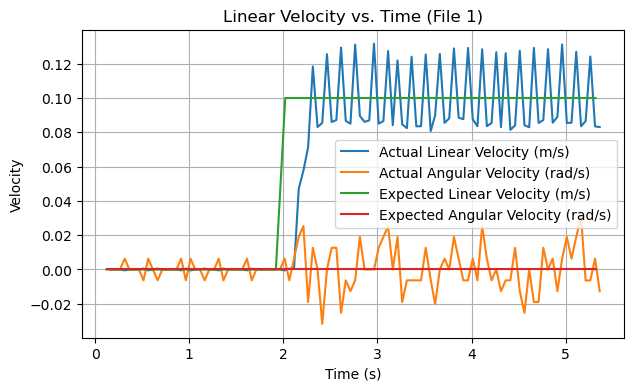

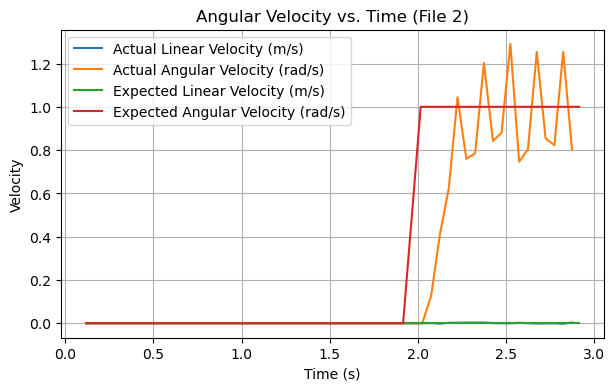

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Load File 1
df1 = pd.read_csv("Linear Velocity Readings.csv")

# Plot
plt.figure(figsize=(7,4))

plt.plot(df1["Time (s)"], df1["Actual Linear Velocity (m/s)"], label="Actual Linear Velocity (m/s)")
plt.plot(df1["Time (s)"], df1["Actual Angular Velocity (rad/s)"], label="Actual Angular Velocity (rad/s)")
plt.plot(df1["Time (s)"], df1["Expected Linear Velocity (m/s)"], label="Expected Linear Velocity (m/s)")
plt.plot(df1["Time (s)"], df1["Expected Angular Velocity (rad/s)"], label="Expected Angular Velocity (rad/s)")

plt.xlabel("Time (s)")
plt.ylabel("Velocity")
plt.title("Linear Velocity vs. Time (File 1)")
plt.legend()
plt.grid(True)
plt.show()

# Load File 2
df2 = pd.read_csv("Angular Velocity Readings.csv")

# Plot
plt.figure(figsize=(7,4))

plt.plot(df2["Time (s)"], df2["Actual Linear Velocity (m/s)"], label="Actual Linear Velocity (m/s)")
plt.plot(df2["Time (s)"], df2["Actual Angular Velocity (rad/s)"], label="Actual Angular Velocity (rad/s)")
plt.plot(df2["Time (s)"], df2["Expected Linear Velocity (m/s)"], label="Expected Linear Velocity (m/s)")
plt.plot(df2["Time (s)"], df2["Expected Angular Velocity (rad/s)"], label="Expected Angular Velocity (rad/s)")

plt.xlabel("Time (s)")
plt.ylabel("Velocity")
plt.title("Angular Velocity vs. Time (File 2)")
plt.legend()
plt.grid(True)
plt.show()
